## DCMtoIcePipeline01
05/27/21 - Initial creation

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
from icevision.all import *
from fastai.medical.imaging import *

In [3]:
import pandas as pd
from datetime import *
import pytz
from icevision.widgets import *

In [4]:
params = dict(
    size=256,
    size_trans=256,
    batch_size=8,
    ds_size=500
    )

In [5]:
path = Path('./')
extra_args = {}

# Laptop Workstation
path_dicom = Path('/host_Data/DataSets/Kaggle-SIIM Covid 19/siim-covid19-detection')

# AZ Server
# path_dicom = Path('/workspace/WSI/SIIM-Covid19-Detection')

path_output_patches = path_dicom / ('DS-COCO_' + str(params['size']))

num2label = {1: 'Negative', 2: 'Typical', 3: 'Indeterminate', 4: 'Atypical'}
classlabels = ['Negative', 'Typical', 'Indeterminate', 'Atypical']

In [6]:
# Parser
parser = parsers.COCOBBoxParser(annotations_filepath=str(path_output_patches) + '/coco_train_annotations_' + str(params['size']) + 'px.json', img_dir=path_output_patches / 'train')

In [7]:
# Parsing
train_rs, valid_rs = parser.parse()

  0%|          | 0/7518 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:136


  0%|          | 0/3292 [00:00<?, ?it/s]

  0%|          | 0/823 [00:00<?, ?it/s]

In [8]:
class_map = ClassMap(classlabels)
print(len(class_map))
class_map

5


<ClassMap: {'background': 0, 'Negative': 1, 'Typical': 2, 'Indeterminate': 3, 'Atypical': 4}>

In [9]:
train_rs[3]

BaseRecord

common: 
	- Image size ImgSize(width=256, height=256)
	- Filepath: /host_Data/DataSets/Kaggle-SIIM Covid 19/siim-covid19-detection/DS-COCO_256/train/bcb4dae91d85_image.png
	- Image: None
	- Image ID: 3013
detection: 
	- Areas: [962]
	- Class Map: <ClassMap: {'background': 0, 'Negative': 1, 'Typical': 2, 'Indeterminate': 3, 'Atypical': 4}>
	- Labels: [3]
	- Is Crowds: [0]
	- BBoxes: [<BBox (xmin:195, ymin:156, xmax:221, ymax:193)>]

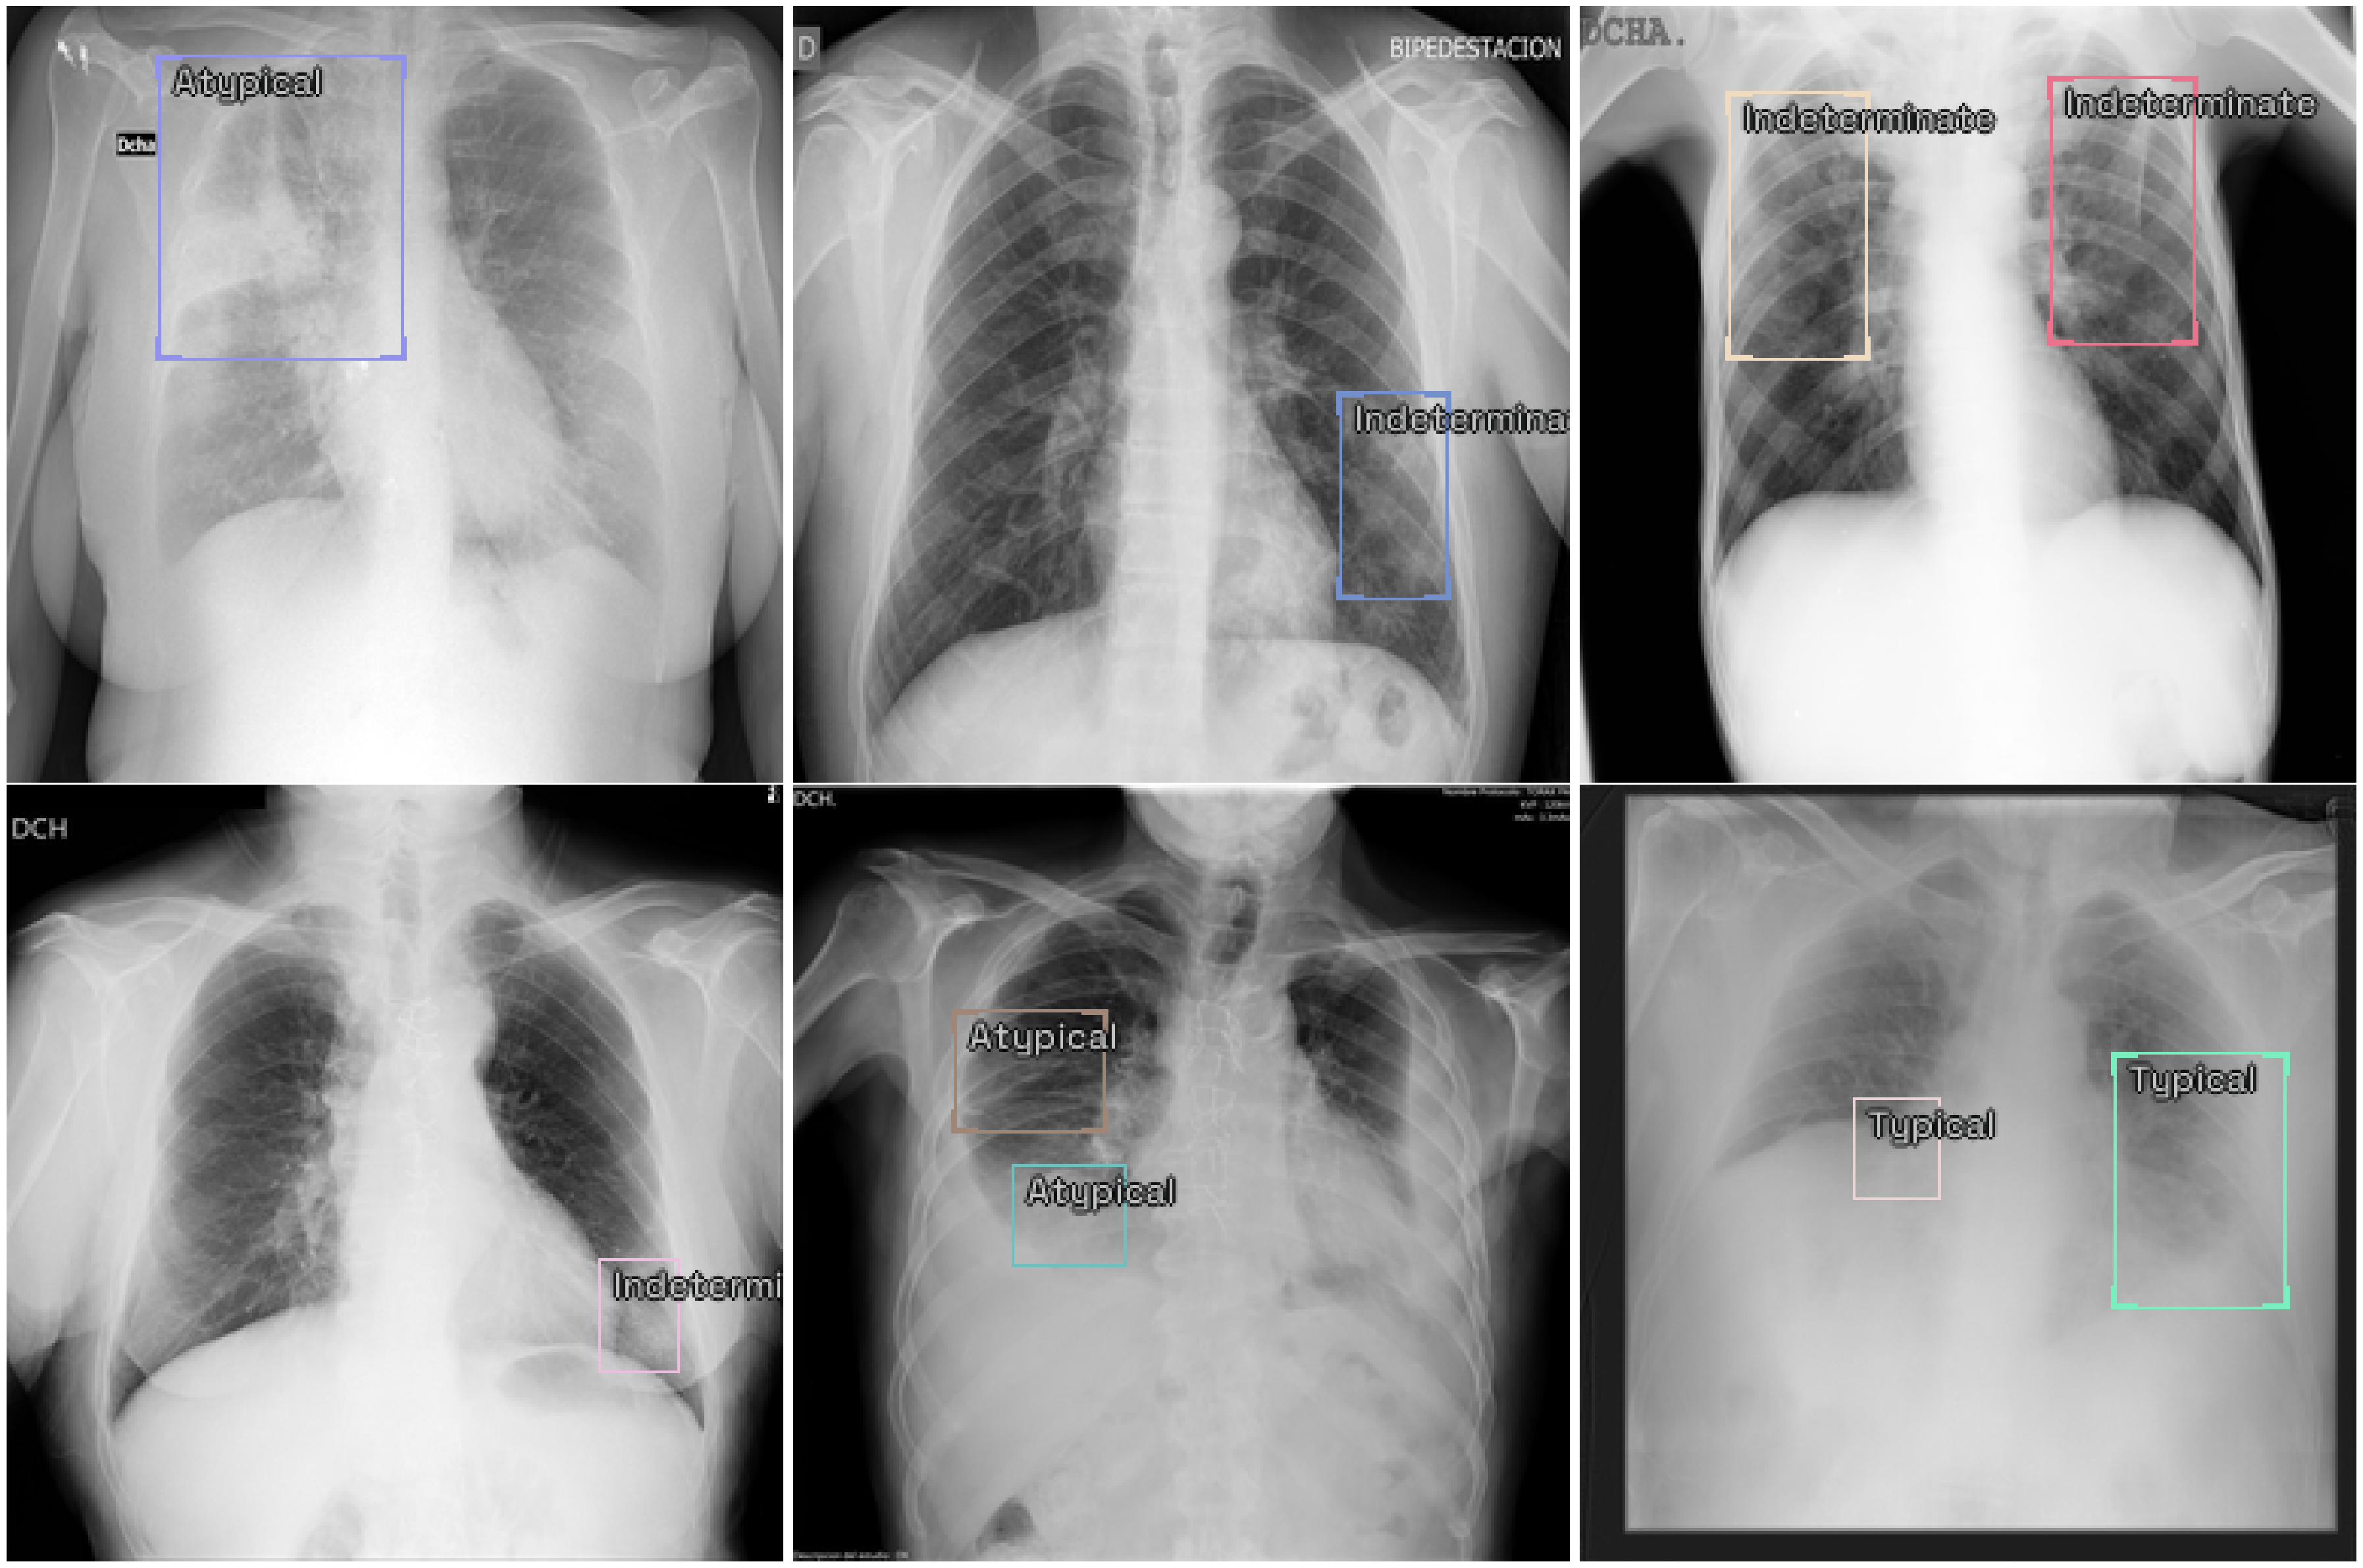

In [10]:
show_records(train_rs[:6], ncols=3, class_map=class_map)

In [11]:
# Transforms
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=params['size'], presize=params['size_trans']), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(params['size']), tfms.A.Normalize()])

In [12]:
# Datasets
train_ds = Dataset(train_rs, train_tfms)
valid_ds = Dataset(valid_rs, valid_tfms)

### Model Selection

In [13]:
# # display_model_choice_ui(mytask="keypoints")
# model_ui = ModelChoiceUI(task="object_detection")
# model_ui.display()

# # add extra arguments for EffDet & Yolo
# extra_args['img_size'] = params['size']

In [14]:
# model_type, backbone = model_ui.get_model_info()
# model_type, backbone

In [15]:
# Just change the value of selection to try another model

selection = 0

extra_args = {}

if selection == 0:
  model_type = models.mmdet.retinanet
  backbone = model_type.backbones.resnet50_fpn_1x

elif selection == 1:
  # The Retinanet model is also implemented in the torchvision library
  model_type = models.torchvision.retinanet
  backbone = model_type.backbones.resnet50_fpn

elif selection == 2:
  model_type = models.ross.efficientdet
#   backbone = model_type.backbones.tf_lite0
  backbone = model_type.backbones.tf_d0
  # The efficientdet model requires an img_size parameter
  extra_args['img_size'] = params['size']

elif selection == 3:
  model_type = models.ultralytics.yolov5
  backbone = model_type.backbones.small
  # The yolov5 model requires an img_size parameter
  extra_args['img_size'] = params['size']

model_type, backbone, extra_args

(<module 'icevision.models.mmdet.models.retinanet' from '/workspace/.virtualenvs/siim-covid19/lib/python3.8/site-packages/icevision/models/mmdet/models/retinanet/__init__.py'>,
 {})

In [16]:
len(class_map)

5

In [17]:
# Instantiate the mdoel
model = model_type.model(backbone=backbone(pretrained=True), num_classes=len(class_map), **extra_args) 

Use load_from_local loader
The model and loaded state dict do not match exactly

size mismatch for bbox_head.retina_cls.weight: copying a param with shape torch.Size([720, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([36, 256, 3, 3]).
size mismatch for bbox_head.retina_cls.bias: copying a param with shape torch.Size([720]) from checkpoint, the shape in current model is torch.Size([36]).


In [18]:
# DataLoaders
train_dl = model_type.train_dl(train_ds, batch_size=params['batch_size'], num_workers=0, shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=params['batch_size'], num_workers=0, shuffle=False)

In [19]:
# model_type.show_batch(first(valid_dl), ncols=4)

## Model & Parameter Setup

In [20]:
params['run_datetime'] = datetime.now(pytz.timezone('US/Pacific')).strftime("%m%d%Y-%H%M")


model_save_name = 'ModelName' + '_'  
model_save_name += str(len(parser.class_map)) + 'cls_' 
model_save_name += str((params['size'])) + 'px_'
model_save_name += str(len(train_ds)) + 'ds_'
model_save_name += params['run_datetime']
print(model_save_name)

ModelName_5cls_256px_3292ds_06152021-0930


In [21]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

In [22]:
learn = model_type.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics)

## Model Training - Stage 1

In [27]:
# learn.freeze()
learn.lr_find()

In [23]:
params.update(lr1 = 1e-3)
params.update (epochs1 = 1)

learn.fit_one_cycle(params['epochs1'], params['lr1'])

epoch,train_loss,valid_loss,COCOMetric,time


In [ ]:
params.update(lr1 = 1e-4)
params.update (epochs1 = 20)

learn.fit_one_cycle(params['epochs1'], params['lr1'])

In [ ]:
params.update(current_saved_model='stage-1-' + model_save_name)
params['current_saved_model']

In [ ]:
learn.save(path/ params['current_saved_model'])

## Pytorch Lightning - Test

In [ ]:
class LightModel(model_type.lightning.ModelAdapter):
    def configure_optimizers(self):
        return SGD(self.parameters(), lr=1e-4)

light_model = LightModel(model, metrics=metrics)

In [ ]:
trainer = pl.Trainer(max_epochs=5, gpus=1)
trainer.fit(light_model, train_dl, valid_dl)

## Review Model Run - Validation Images

In [ ]:
learn.load(path/params['current_saved_model'])

In [ ]:
model_type.show_results(model, valid_ds, detection_threshold=.3)